# ESGF-VA - Global Surface Air Temperature changes in future scenarios

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products, which has been adapted to work with the ESGF Virtual Aggregation. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

**E. Cimadevilla** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook computes Global Surface Air Temperature (GSAT) changes relative to the 1995–2014 and 1850–1900 averages, according to CMIP6 climate models.

In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## Data catalog

The `gsat-pangeo.csv` catalog include the paths to the Google Cloud datasets considered in this notebook. We can analyze it with Pandas.

In [3]:
df = pd.read_csv("gsat-esgf.csv").set_index("model_run")
df

,historical,ssp585,ssp126,ssp245,ssp370
model_run,,,,,
AWI-CM-1-1-MR_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CAMS-CSM1-0_r2i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CanESM5_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CESM2-WACCM_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CMCC-CM2-SR5_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CNRM-CM6-1_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CNRM-CM6-1-HR_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CNRM-ESM2-1_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
GFDL-CM4_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN,NaN


## Data loading

We load the data into [xarray](https://docs.xarray.dev/en/stable/) datasets.

In [4]:
def load_datasets(locations, experiment):
    dss = []
    for model_run, location in locations.items():
        if location is np.nan:
            continue
        
        model = model_run.split("_")[0]
        member = model_run.split("_")[1]

        ds = xarray.open_dataset(
            location,
            drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds", "time_bounds"]).sel(
            variant_label=member.encode("ascii"))

        if experiment.startswith("ssp"):
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "20991230"))
            else:
                ds = ds.sel(time=slice("20150101", "20991231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{member}"
        dss.append(ds.chunk({"time": 100}))

    return dss

Load the different scenarios.

In [5]:
historical_dss = load_datasets(df["historical"], "historical")
ssp126_dss = load_datasets(df["ssp126"], "ssp126")
ssp245_dss = load_datasets(df["ssp245"], "ssp245")
ssp370_dss = load_datasets(df["ssp370"], "ssp370")
ssp585_dss = load_datasets(df["ssp585"], "ssp585")

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/tmp/ipykernel_2844882/1429407159.py:10: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_dataset(
/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Preview one of the datasets.

In [6]:
historical_dss[0]["tas"]

<xarray.DataArray 'tas' (time: 60265, lat: 192, lon: 384)> Size: 18GB
dask.array<xarray-tas, shape=(60265, 192, 384), dtype=float32, chunksize=(100, 192, 384), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 2kB -89.28 -88.36 -87.42 ... 87.42 88.36 89.28
  * lon            (lon) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
    height         float64 8B ...
  * time           (time) datetime64[ns] 482kB 1850-01-01T12:00:00 ... 2014-1...
    variant_label  |S64 64B b'r1i1p1f1'
Attributes:
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    temp2
    cell_methods:     area: time: mean
    cell_measures:    area: areacella
    history:          2019-05-09T03:07:14Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1 192 384]

## Computation

The functions that compute global surface average temperatures (GSAT) is available in the `gsat.py` module. We implement weighted and unweighted GSAT.

In [7]:
from gsat import weighted, unweighted

### Weighted

Due to the implementation of weighted operations between xarray and Dask, this operation is more expensive in comparison with the unweighted version. This is due to Dask tasks that have to wait for each other in order to carry out weighted operations.

459 GB

-  5h 31min 44s

In [8]:
%%time

mean_hist_1995_2014, mean_hist_1850_1900, mean_hist, mean_ssp126, mean_ssp245, mean_ssp370, mean_ssp585 = weighted(
    8,
    historical_dss, ssp126_dss, ssp245_dss, ssp370_dss, ssp585_dss)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i

In [9]:
m_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245 = (mean_ssp245 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

m_hist_18   = (mean_hist   - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126_18 = (mean_ssp126 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245_18 = (mean_ssp245 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370_18 = (mean_ssp370 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585_18 = (mean_ssp585 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

q_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]

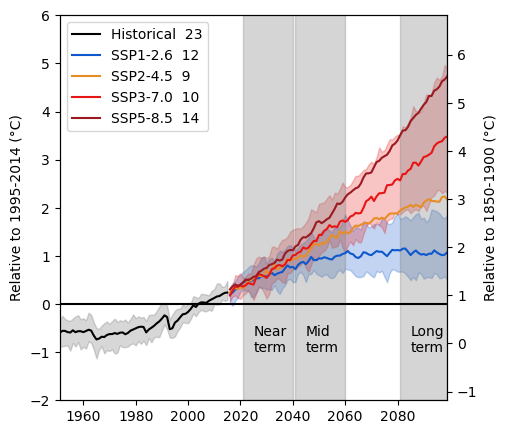

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

ax.fill_between(q_hist.time,
                q_hist.sel(quantile=.05),
                q_hist.sel(quantile=.95),
                color="#616161", alpha=0.25)
ax.fill_between(q_ssp126.time,
                q_ssp126.sel(quantile=.05),
                q_ssp126.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.fill_between(q_ssp370.time,
                q_ssp370.sel(quantile=.05),
                q_ssp370.sel(quantile=.95),
                color="#e81515", alpha=0.25)

ytop = 6
ax.set_ylabel("Relative to 1995-2014 (°C)")
ax.axhline(y=0, color="black")
ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")
ax.fill_between(
    m_ssp126["time"].sel(time=slice("20200101", "20400101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20400101", "20600101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20800101", None)),
    -2, ytop+.82, alpha=.33, color="grey")

ax2 = ax.twinx()
ax2.set_ylabel("Relative to 1850-1900 (°C)")
ax2.set_ylim(bottom=-2+.82, top=ytop+.82)
ax.set_ylim([-2, ytop])

ax.plot(m_hist.time, m_hist, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
ax.plot(m_ssp126.time, m_ssp126, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
ax.plot(m_ssp245.time, m_ssp245, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
ax.plot(m_ssp370.time, m_ssp370, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
ax.plot(m_ssp585.time, m_ssp585, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

# ax2.plot(m_hist_18.time, m_hist_18, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
# ax2.plot(m_ssp126_18.time, m_ssp126_18, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
# ax2.plot(m_ssp245_18.time, m_ssp245_18, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
# ax2.plot(m_ssp370_18.time, m_ssp370_18, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
# ax2.plot(m_ssp585_18.time, m_ssp585_18, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

ax.margins(0)
ax2.margins(0)
ax.legend()

plt.savefig("pangeo-weighted.pdf")

### Unweighted

In contrast to the weighted version, unweighted tasks in the Dask graph do not depend on each other for the computation of the final result. Thus, we can measure the actual throughtput of the infrastructure, since we are not spending time within the computation runtime.

469 GB

- 4h 25min 11s

In [14]:
%%time

un_mean_hist_1995_2014, un_mean_hist_1850_1900, un_mean_hist, un_mean_ssp126, un_mean_ssp245, un_mean_ssp370, un_mean_ssp585 = unweighted(
    8,
    historical_dss, ssp126_dss, ssp245_dss, ssp370_dss, ssp585_dss)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1


oc_open: server error retrieving url: code=500 message="Premature end of chunk coded message body: closing chunk expected"oc_open: server error retrieving url: code=500 message="Premature end of chunk coded message body: closing chunk expected"

An error occurred: [Errno -70] NetCDF: DAP server error: b'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CAMS_CAMS-CSM1-0_historical_day_gn_v20200716/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CAMS_CAMS-CSM1-0_historical_day_tas_gn_v20200716.ncml'
Retrying...
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
An error occurred: NetCDF: DAP failure
Retrying...
Model_

Error:curl error: SSL connect error
curl error details: 
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1


An error occurred: [Errno -68] NetCDF: I/O failure: b'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp126_day_gn_v20190710/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp126_day_tas_gn_v20190710.ncml'
Retrying...
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: IITM-ESM_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: IITM-ESM_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: UKESM1-0-LL

Error:curl error: Couldn't resolve host name
curl error details: 
Note:Caching=1
Error:curl error: Couldn't resolve host name
curl error details: 
Error:curl error: Couldn't resolve host name
curl error details: 
Note:Caching=1
Error:curl error: Couldn't resolve host name
curl error details: 
Error:curl error: Couldn't resolve host name
curl error details: 
Note:Caching=1
Error:curl error: Couldn't resolve host name
curl error details: 
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1


An error occurred: [Errno -68] NetCDF: I/O failure: b'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_tas_gr_v20191021.ncml'
Retrying...
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
CPU times: user 1min 58s, sys: 4.67 s, total: 2min 2s
Wall time: 4h 25min 11s


In [15]:
m_hist   = (un_mean_hist   - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126 = (un_mean_ssp126 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245 = (un_mean_ssp245 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370 = (un_mean_ssp370 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585 = (un_mean_ssp585 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

m_hist_18   = (un_mean_hist   - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp126_18 = (un_mean_ssp126 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp245_18 = (un_mean_ssp245 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp370_18 = (un_mean_ssp370 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]
m_ssp585_18 = (un_mean_ssp585 - un_mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))["tas"]

q_hist   = (un_mean_hist   - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp126 = (un_mean_ssp126 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp370 = (un_mean_ssp370 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]
q_ssp585 = (un_mean_ssp585 - un_mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))["tas"]

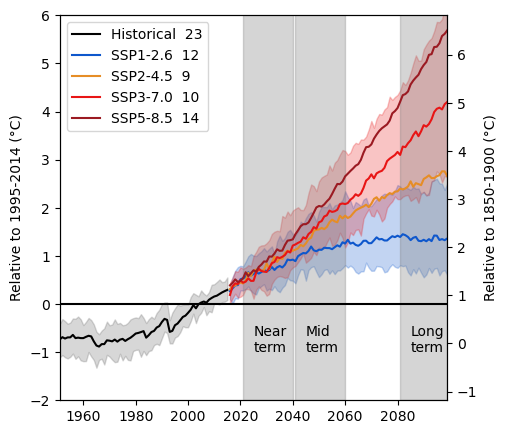

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

ax.fill_between(q_hist.time,
                q_hist.sel(quantile=.05),
                q_hist.sel(quantile=.95),
                color="#616161", alpha=0.25)
ax.fill_between(q_ssp126.time,
                q_ssp126.sel(quantile=.05),
                q_ssp126.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.fill_between(q_ssp370.time,
                q_ssp370.sel(quantile=.05),
                q_ssp370.sel(quantile=.95),
                color="#e81515", alpha=0.25)

ytop = 6
ax.set_ylabel("Relative to 1995-2014 (°C)")
ax.axhline(y=0, color="black")
ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")
ax.fill_between(
    m_ssp126["time"].sel(time=slice("20200101", "20400101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20400101", "20600101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20800101", None)),
    -2, ytop+.82, alpha=.33, color="grey")

ax2 = ax.twinx()
ax2.set_ylabel("Relative to 1850-1900 (°C)")
ax2.set_ylim(bottom=-2+.82, top=ytop+.82)
ax.set_ylim([-2, ytop])

ax.plot(m_hist.time, m_hist, color="#010101", label=f"Historical  {len(un_mean_hist['member'])}")
ax.plot(m_ssp126.time, m_ssp126, color="#0e57cc", label=f"SSP1-2.6  {len(un_mean_ssp126['member'])}")
ax.plot(m_ssp245.time, m_ssp245, color="#e68d26", label=f"SSP2-4.5  {len(un_mean_ssp245['member'])}")
ax.plot(m_ssp370.time, m_ssp370, color="#e81515", label=f"SSP3-7.0  {len(un_mean_ssp370['member'])}")
ax.plot(m_ssp585.time, m_ssp585, color="#9b1a22", label=f"SSP5-8.5  {len(un_mean_ssp585['member'])}")

# ax2.plot(m_hist_18.time, m_hist_18, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
# ax2.plot(m_ssp126_18.time, m_ssp126_18, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
# ax2.plot(m_ssp245_18.time, m_ssp245_18, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
# ax2.plot(m_ssp370_18.time, m_ssp370_18, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
# ax2.plot(m_ssp585_18.time, m_ssp585_18, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

ax.margins(0)
ax2.margins(0)
ax.legend()

plt.savefig("pangeo-unweighted.pdf")

## Task graphs

In [132]:
u = historical_dss[0]["tas"].isel(time=slice(0,221*3)).mean(["lat", "lon"])
w = historical_dss[0]["tas"].isel(time=slice(0,221*3)).weighted(
    np.cos(np.deg2rad(historical_dss[0].coords["lat"]))).mean(["lat", "lon"])

In [133]:
u.data.visualize(filename="tg-unweighted.pdf", optimize_graph=True)

In [134]:
w.data.visualize(filename="tg-weighted.pdf", optimize_graph=True)

To bebug using the distributed scheduler:

```python
from dask.distributed import Client, LocalCluster
from dask.distributed import performance_report

cluster = LocalCluster(processes=True,threads_per_worker=1)
client = Client(cluster)
```